In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#ambil data dari csv
df = pd.read_csv('./Gabungan_IHSG_2010-2020.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df
#df = web.DataReader('^JKSE', data_source='yahoo', start='2010-01-01', end='2018-12-31') 
#df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,2533.947998,2576.055908,2532.895996,2575.413086,2575.312988,18339300
2010-01-05,2575.616943,2606.069092,2575.616943,2605.277100,2605.175537,57043800
2010-01-06,2605.480957,2622.115967,2587.709961,2603.297119,2603.195557,51569100
2010-01-07,2603.500977,2611.603027,2570.272949,2586.895020,2586.794189,45510800
2010-01-08,2586.792969,2614.535889,2583.846924,2614.370117,2614.268311,73723500
...,...,...,...,...,...,...
2020-12-22,6146.645996,6174.458984,6010.210938,6023.289063,6023.289063,250085200
2020-12-23,6061.848145,6104.354980,5853.261230,6008.708984,6008.708984,203528500
2020-12-28,6067.000000,6095.007813,5979.904785,6093.554199,6093.554199,180855700


In [3]:
df.shape

(2679, 6)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


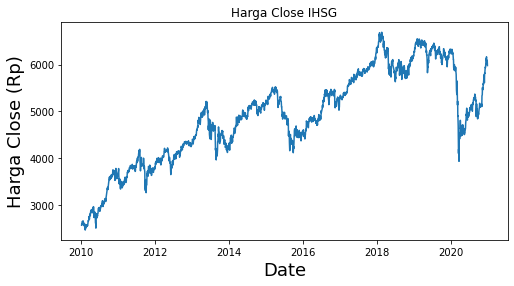

In [4]:
plt.figure(figsize=(8,4))
plt.title('Harga Close IHSG')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Harga Close (Rp)', fontsize=18)
plt.show()

In [39]:
#Ambil data CLOSE saja
data=df.filter(['Open', 'High', 'Low', 'Close', 'Adj Close'])
dataset=data.values
training_data_len=2192 #data dari 2010-2018
#training_data_len=math.ceil(len(dataset)* .8)
data.shape

(2679, 5)

In [6]:
#Scaling Data
scaler=StandardScaler()
scaled_data=scaler.fit_transform(dataset)
scaled_data

array([[-2.35827546, -2.34286582, -2.33240983, -2.32133551, -2.32122182],
       [-2.31631172, -2.31262684, -2.28934632, -2.29119657, -2.29108577],
       [-2.28623643, -2.29645925, -2.27715633, -2.29319477, -2.29308389],
       ...,
       [ 1.19977167,  1.20255974,  1.14223954,  1.22919342,  1.22924069],
       [ 1.24581534,  1.25178965,  1.18941511,  1.17128481,  1.17133481],
       [ 1.1847875 ,  1.16322846,  1.12420102,  1.11365855,  1.11371128]])

In [7]:
#bikin scaled training dataset
train_data=scaled_data[0:training_data_len, :]

#split x_train & y_train
x_train = []
y_train = []

train_data.shape

(2192, 5)

In [8]:
n_future = 1
n_past = 10

#isi trainx dan trainy sesuai n nya
for i in range(n_past, len(train_data) - n_future +1): # i = range dari 365 - 3965 (365, 3969-3-1)
    x_train.append(train_data[i - n_past:i, 0:train_data.shape[1]]) #ambil data dari 365 hari yang lalu (0:365, 0:5)
    y_train.append(train_data[i + n_future - 1:i + n_future, 0]) #ambil data buat prediksi (367:368, 0)

In [9]:
#n_past=10
#for i in range(n_past, len(train_data)):
    #x_train.append(train_data[i-n_past:i, 0])
    #y_train.append(train_data[i,0])

In [10]:
#Convert ke Array
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(2182, 10, 5)

In [11]:
n_fitur=5 #fitur close 
#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],n_fitur))
#x_train.shape

## ------ RANDOM FOREST ------

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

nsamples, nx, ny = x_train.shape
d2_trainX = x_train.reshape((nsamples,nx*ny))

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(d2_trainX, y_train)

<ipython-input-12-ed668aa5d0cb>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(d2_trainX, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [13]:
#Bikin testing data set
test_data=scaled_data[training_data_len-n_past:, :]
x_test=[]
y_test=dataset[training_data_len:, -1:]
for i in range(n_past, len(test_data)):
    x_test.append(test_data[i-n_past:i,0:5])

In [14]:
#convert data ke numpy array
x_test = np.array(x_test)
x_test.shape

(487, 10, 5)

In [15]:
nsamples, nx, ny = x_test.shape
d2_testX = x_test.reshape((nsamples,nx*ny))

In [31]:
#prediksi dari model
predictions_rf=rf.predict(d2_testX) #prediksi
predictions_rf = predictions_rf.reshape(predictions_rf.shape[0],1)
predictions_rf_copies = np.repeat(predictions_rf, train_data.shape[1], axis=-1)
predictions_rf_inv=scaler.inverse_transform(predictions_rf_copies)[:,0]
predictions_rf_copies.shape

(487, 5)

<ipython-input-33-946aa8180c66>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_rf['Predictions']=predictions_rf_inv


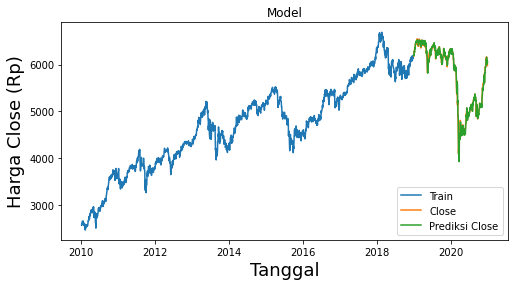

In [33]:
#Plot data
train_rf=data[:training_data_len]
valid_rf=data[training_data_len:]
valid_rf['Predictions']=predictions_rf_inv

#Visualisasi data
plt.figure(figsize=(8,4))
plt.title('Model')
plt.xlabel('Tanggal', fontsize=18)
plt.ylabel('Harga Close (Rp)', fontsize=18)
plt.plot(train_rf['Close'])
plt.plot(valid_rf[['Close', 'Predictions']])
plt.legend(['Train', 'Close', 'Prediksi Close'], loc='lower right')
plt.show()

In [35]:
valid_rf[['Close','Predictions']]

,Close,Predictions
Date,,
2019-01-02,6181.174805,6195.602208
2019-01-03,6221.009766,6186.759401
2019-01-04,6274.540039,6212.805171
2019-01-07,6287.224121,6276.870972
2019-01-08,6262.847168,6283.766452
...,...,...
2020-12-22,6023.289063,6155.085833
2020-12-23,6008.708984,6032.281831
2020-12-28,6093.554199,6010.084114


In [34]:
y_test_scaled = scaler.fit_transform(y_test)
predictions_scaled = scaler.fit_transform(predictions_rf_copies)
rmse_rf = np.sqrt(np.mean((predictions_scaled-y_test_scaled)**2))
rmse_rf

0.10383360877272914

In [37]:
%store rmse_rf
%store predictions_rf_inv

Stored 'rmse_rf' (float64)
Stored 'predictions_rf_inv' (ndarray)
